In [1]:
import pyemma
pyemma.__version__
import numpy as np
import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys
import shutil
import os
from pyemma.util.contexts import named_temporary_file
from matplotlib.pyplot import cm
from collections import OrderedDict
import mdtraj as md
import itertools
import time
import torch

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(4, 4))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1],marker='.')

In [2]:
device = torch.cuda.set_device(0)

torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)

In [8]:
!nvidia-smi

Sun Oct 18 15:48:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   30C    P8    18W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 29%   27C    P8    18W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [21]:
traj = md.load_dcd('../proteinL_1hz5/nativeruns/trajectory.00.dcd',top='../proteinL_1hz5/1hz5.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = np.arange(0,62)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1:]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=0.4,periodic=False)
inp = pyemma.coordinates.load('../proteinL_1hz5/nativeruns/trajectory.00.dcd', features=feat)

In [10]:
import indices
from indices.base import BaseComparisons as bc

In [23]:
all_start = time.time()
batch_size=100000
all_input = list(itertools.combinations(inp, 2))
#inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
all_input

[(array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)),
 (array([1., 1., 0., ..., 1., 1., 1.], dtype=float32),
  array([1., 1., 0., ..., 1., 0., 1.], dtype=float32)),
 

In [31]:
all_start = time.time()
batch_size=500000
all_input = list(itertools.combinations(inp, 2))
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
temp_start = time.time()
temp_c = torch.zeros((int(len(inp_sliced[0])),3))
temp_input = torch.as_tensor(np.array(inp_sliced[0]),device=device)

product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
for row in range(3):
    temp_c[:,row] = torch.sum(product==row,axis=1)
# if i == 0:
#     all_c = temp_c
# else:
#     all_c = torch.cat((all_c,temp_c),axis=0)
# print('all_c shape = ', all_c.shape)
temp_end = time.time()
temp_time = temp_end - temp_start
print('step {} time = '.format(0),temp_time)

step 0 time =  21.543421268463135


In [34]:
all_start = time.time()
batch_size=500000
all_input = list(itertools.combinations(inp, 2))
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
temp_start = time.time()
temp_c = np.zeros((int(len(inp_sliced[0])),3))
temp_input = np.array(inp_sliced[0])

product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
for row in range(3):
    temp_c[:,row] = np.sum(product==row,axis=1)
# if i == 0:
#     all_c = temp_c
# else:
#     all_c = torch.cat((all_c,temp_c),axis=0)
# print('all_c shape = ', all_c.shape)
temp_end = time.time()
temp_time = temp_end - temp_start
print('step {} time = '.format(0),temp_time)

step 0 time =  11.209821224212646


In [ ]:
!nvidia-smi

In [ ]:
# torch version

# %%timeit -n1 -r1 

all_start = time.time()
# inp_sliced=[inp[i*1000:(i+1)*1000] for i in range(int(len(inp)/1000))]
# if int(len(inp_sliced)) < len(inp)/1000:
#     inp_sliced.append(inp[len(inp_sliced)*1000:])
batch_size=500000
all_input = list(itertools.combinations(inp, 2))
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = torch.zeros((int(len(inp_sliced[i])),3))
    temp_input = torch.tensor(inp_sliced[i])

    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = torch.sum(product==row,axis=1).T
    if i == 0:
        all_c = temp_c
    else:
        all_c = torch.cat((all_c,temp_c),axis=0)
    print('all_c shape = ', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time = '.format(i),temp_time)

###calculate similarity
simi=all_c[:,0]+all_c[:,2]
arr = np.zeros((len(inp),len(inp)))
indices = np.tril_indices(len(inp),k=-1)
arr[indices] = simi
print('final matrix shape = ', arr.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time = ', all_time)

In [35]:
# %%timeit -n1 -r1 

all_start = time.time()
# inp_sliced=[inp[i*1000:(i+1)*1000] for i in range(int(len(inp)/1000))]
# if int(len(inp_sliced)) < len(inp)/1000:
#     inp_sliced.append(inp[len(inp_sliced)*1000:])
batch_size=1000000
all_input = list(itertools.combinations(inp, 2))
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape = ', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time = '.format(i),temp_time)

###calculate similarity
simi=all_c[:,0]+all_c[:,2]
arr = np.zeros((len(inp),len(inp)))
indices = np.tril_indices(len(inp),k=-1)
arr[indices] = simi
print('final matrix shape = ', arr.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time = ', all_time)

all_c shape =  (1000000, 3)
step 0 time =  22.059252738952637
all_c shape =  (2000000, 3)
step 1 time =  22.746452569961548
all_c shape =  (3000000, 3)
step 2 time =  22.602570295333862
all_c shape =  (4000000, 3)
step 3 time =  23.518176555633545
all_c shape =  (5000000, 3)
step 4 time =  23.149214506149292
all_c shape =  (6000000, 3)
step 5 time =  22.82439613342285
all_c shape =  (7000000, 3)
step 6 time =  23.553019762039185
all_c shape =  (8000000, 3)
step 7 time =  22.779515027999878
all_c shape =  (9000000, 3)
step 8 time =  23.49937605857849
all_c shape =  (10000000, 3)
step 9 time =  22.91548776626587
all_c shape =  (11000000, 3)
step 10 time =  24.4758882522583
all_c shape =  (12000000, 3)
step 11 time =  22.8569917678833
all_c shape =  (13000000, 3)
step 12 time =  23.805599212646484
all_c shape =  (14000000, 3)
step 13 time =  23.047932863235474
all_c shape =  (15000000, 3)
step 14 time =  24.456562757492065
all_c shape =  (16000000, 3)
step 15 time =  23.181466102600098
al

In [37]:
arr

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [1856.,    0.,    0., ...,    0.,    0.,    0.],
       [1858., 1848.,    0., ...,    0.,    0.,    0.],
       ...,
       [1767., 1820., 1770., ...,    0.,    0.,    0.],
       [1762., 1765., 1775., ..., 1771.,    0.,    0.],
       [1802., 1783., 1780., ..., 1811., 1810.,    0.]])

In [164]:
all_compare=np.zeros((len(inp),len(inp)))

In [30]:
simi_1 = []
i=0
n=0
b=0
while b < len(inp)-1:
    simi_1.append(simi[n:n+len(inp)-b-1])
    n+=len(inp)-1-b
    b+=1

In [34]:
len(simi_1[622])

2

In [66]:
arr

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [1856.,    0.,    0., ...,    0.,    0.,    0.],
       [1858., 1848.,    0., ...,    0.,    0.,    0.],
       ...,
       [1767., 1820., 1770., ...,    0.,    0.,    0.],
       [1762., 1765., 1775., ..., 1771.,    0.,    0.],
       [1802., 1783., 1780., ..., 1811., 1810.,    0.]])

In [68]:
np.unravel_index(np.argmax(arr, axis=None), arr.shape)

(6547, 3890)

In [71]:
#%%timeit -n1 -r1
df = pd.DataFrame(arr,columns=['{}'.format(i) for i in range(1,len(inp)+1)])
new_max = np.argmax(df, axis=None)
new_max

65460796

In [60]:
import pandas  as pd
all_start=time.time()
df = pd.DataFrame(arr,columns=['{}'.format(i) for i in range(1,len(inp)+1)])
inp_copy=inp
dic={}
while df.shape[0] > 2:
    ###update df
    
    new_max=np.argmax(df, axis=None)     ###2.5s

    del_index = np.unravel_index(new_max, df.shape)
    max_value = df.to_numpy()[del_index[0]][del_index[1]] ###0.1

    ###get temp inp
    delete_row=[int(i) for i in df.columns[del_index[0]].split(',') ]
    delete_column=[int(i) for i in df.columns[del_index[1]].split(',') ]
    delete_all=delete_column+delete_row
    insert_index='{}'.format(delete_all)[1:-1]   ###0.1

    df.drop(columns=['{}'.format(delete_column)[1:-1],'{}'.format(delete_row)[1:-1]],axis=1,inplace=True)
    df.drop(index=[*del_index],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    temp_w_sim=[]            ###1

    ###get temp inp
   # print(df.columns)
    columns=[[int(d) for d in [*i.split(',')]] for i in df.columns]
    temp_inp=[[inp_copy[d-1] for d in m] for m in columns]    ###0.1s

    ###perform comparison
    
    for i in temp_inp:
        compare=bc(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
        temp_w_sim.append(compare.total_w_sim)         ###1s

    temp_start = time.time()
  #  inp_copy = temp_inp
    temp_w_sim=[0]+temp_w_sim
    df.loc[-1] = [0]*df.shape[1] # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index
   # print(df.shape)
    if df.shape[0] % 10 == 0:
        all_end = time.time()
        all_time = all_end - all_start
        print('merge 10 clusters time = ', all_time)
    df.insert(loc=0, column=insert_index, value=temp_w_sim)

    dic[insert_index]=max_value
    temp_end = time.time() 
    temp_time = temp_end - temp_start           
    print('step {} time = '.format(df.shape[0]),temp_time)  ###1s


step 9997 time =  0.9660205841064453
step 9996 time =  0.8962464332580566
step 9995 time =  0.888728141784668
step 9994 time =  0.8999588489532471
step 9993 time =  0.9004292488098145
step 9992 time =  1.029186487197876


KeyboardInterrupt: 

In [42]:
%timeit?

(0.0, 1.5)

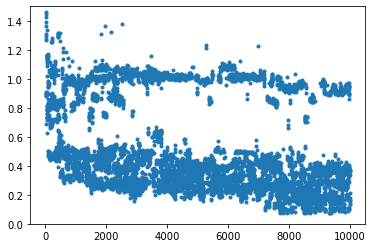

In [382]:
traj = md.load_dcd('../proteinL_1hz5/nativeruns/trajectory.00.dcd',top='../proteinL_1hz5/1hz5.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinL_1hz5/1hz5.pdb')
len(traj)
all_CA=topfile.select("backbone==1")
all_CA
rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#list(rmsd)
plt.scatter(range(len(rmsd)),list(rmsd),marker='.')
plt.ylim(0,1.5)

In [343]:
traj_inp=traj[::2][::8]
len(traj_inp)
a=traj_inp[0]
b=a.join(traj_inp[1])
b

<mdtraj.Trajectory with 2 frames, 941 atoms, 62 residues, without unitcells at 0x2b66220396d0>

In [349]:
all_clust=[[int(d) for d in [*i.split(',')]] for i in list(dic.keys())]
for i in all_clust:
    traj_comp=traj_inp[i[0]-1]
    for d in range(1,len(i)):
        
        traj_comp=traj_comp.join(traj_inp[i[d]-1])
    rmsd=md.rmsd(traj_comp,pdb)
    print(rmsd)

[0.45191553 0.41041148]
[0.45682618 0.43172675]
[0.55165714 0.52650946]
[0.46846431 0.46138975]
[0.42842755 0.43697485]
[0.42771235 0.43172076]
[0.4197433  0.43772084]
[0.41503188 0.4199123 ]
[0.58866245 0.61514485]
[0.46375164 0.44804844]
[0.34356767 0.36820877]
[0.42211354 0.4096775 ]
[0.54578346 0.5405423 ]
[0.540984  0.5380691]
[0.5898592 0.5727246]
[0.44917795 0.45365977]
[0.40846294 0.40056756]
[0.4265537 0.4270601]
[0.2137676  0.22535732]
[0.3052421  0.32588163]
[0.65835637 0.6540547 ]
[0.46752602 0.49094155]
[0.44907022 0.45036107]
[0.44367665 0.4263776 ]
[0.51421845 0.51937735]
[1.0456856 1.0409871]
[0.45682618 0.43172675 0.45191553 0.41041148]
[0.2110431  0.21297054]
[0.4387004 0.4435114]
[0.59874904 0.5882562 ]
[0.48460528 0.47708696]
[0.41340682 0.35528138]
[0.42925367 0.4501954 ]
[0.42842755 0.43697485 0.46846431 0.46138975]
[0.5144538  0.49580815]
[1.101368  1.0778146]
[0.541579 0.527852]
[0.46254614 0.41973743]
[0.40026593 0.41281897]
[0.48522592 0.47707257]
[0.5067804 0

[0.46254614 0.41973743 0.42771235 0.43172076 0.4905149  0.41627744
 0.4289973  0.47794133]
[1.0294546 1.0198803 1.0468075 1.0430164]
[1.050785  1.0381999 1.0461097 1.0399781]
[0.5042172  0.47769347 0.4838337  0.4864587 ]
[0.4906844  0.45420218 0.4736255  0.49215317]
[0.5053849  0.51642644 0.48522592 0.47707257]
[0.71610916 0.70554775]
[0.39252496 0.39031205]
[0.64200616 0.63916457]
[0.535133   0.53784966]
[0.51688516 0.50341254]
[0.47020948 0.4741697 ]
[1.0288748 1.0513501]
[0.32867643 0.30142176]
[0.5017338 0.5010569]
[0.5017338  0.5010569  0.51421845 0.51937735]
[0.4006362  0.40843847 0.4265537  0.42705977 0.38833684 0.41162974]
[0.47729817 0.43088582 0.42842755 0.43697485 0.46846431 0.46138975
 0.4197433  0.43772084 0.44907022 0.45036107 0.42057168 0.41695315
 0.42718583]
[0.55885357 0.5611994  0.55942106 0.5610697 ]
[0.8530034 0.8593969 0.8584679 0.8708364]
[0.38312507 0.37419137 0.35554674 0.36354136]
[0.51688516 0.50341254 0.5045248  0.5101768 ]
[0.44037884 0.4509825  0.42805222 

[0.43602446 0.4231838  0.4387004  0.4435114  0.44905576 0.4239345
 0.44037884 0.4509825  0.42805222 0.4361928  0.4333918  0.40406573
 0.41896096]
[0.8530034  0.8593969  0.8584679  0.8708364  0.86825854 0.8848309 ]
[0.45963168 0.44299367 0.44041303 0.45669982 0.45865244 0.4536057 ]
[0.30870688 0.28798467 0.31194532 0.3183674  0.3052421  0.32588163
 0.31175438 0.33370107 0.2993237  0.29777858 0.33833307 0.28555322
 0.3029877  0.26623818]
[1.0358951 1.0422885 1.0402057 1.0232173 1.0354398 1.0259608 1.0256529
 1.0237818]
[0.255244   0.25800553 0.26287243 0.24934793 0.25147966 0.2513192
 0.2715794  0.2602124 ]
[0.51688516 0.50341254 0.5045248  0.5101768  0.530943   0.51969916]
[0.20698406 0.22530378 0.22513098 0.1956415  0.20828731 0.23355107
 0.19154459 0.20672254 0.19957441 0.25066745]
[0.906989  0.8832352 0.919498  0.8781448]
[0.5648702 0.5698316 0.5668024 0.5795327]
[0.41340682 0.35528138 0.34356767 0.36820877 0.38879752 0.37200612
 0.3833945  0.39855754 0.37380323 0.434788   0.38312507

[0.5053849  0.51642644 0.48522592 0.47707257 0.5111853  0.46602222
 0.51993626 0.4565137  0.50671226 0.49162227 0.51688516 0.50341254
 0.5045248  0.5101768  0.530943   0.51969916]
[1.0787704 1.0743505 1.070729  1.0694718 1.0855906 1.0844767 1.0875857
 1.078288  1.0694431]
[0.28600714 0.23516405 0.2520171  0.27920341 0.28705025 0.32067224
 0.32867643 0.30142176]
[0.46048552 0.4677324  0.48460528 0.47708696 0.49515468 0.48889077
 0.4930588  0.47247127 0.50501055 0.4678361  0.47020948 0.4741697
 0.4643222  0.47028977]
[1.0136286 1.0369759 1.0383165 1.0526288 1.099595 ]
[1.0391128 1.0628451]
[0.4121258  0.34790772 0.39079067 0.38212287 0.3407671  0.37821513
 0.3731798  0.33761185 0.35463816 0.3412426 ]
[0.46254614 0.41973743 0.42771235 0.43172076 0.4905149  0.41627744
 0.4289973  0.47794133 0.43900222 0.44324955 0.435145   0.45682618
 0.43172675 0.45191553 0.41041148 0.44367665 0.4263776  0.44917795
 0.45365977 0.46752602 0.49094155 0.43453997 0.48318845 0.43940657
 0.46525443 0.4755201  0

[0.4121258  0.34790772 0.39079067 0.38212287 0.3407671  0.37821513
 0.3731798  0.33761185 0.35463816 0.3412426  0.3502104  0.36175424
 0.3705054  0.33422467]
[0.3255917  0.34722397 0.29753715 0.31127882 0.31375816 0.31773764
 0.39239502 0.3406323  0.40289927 0.41765723 0.33701882 0.40111157]
[0.43602446 0.4231838  0.4387004  0.4435114  0.44905576 0.4239345
 0.44037884 0.4509825  0.42805222 0.4361928  0.4333918  0.40406573
 0.41896096 0.33443537 0.59581673]
[0.71610916 0.70554775 0.6707155 ]
[0.28600714 0.23516405 0.2520171  0.27920341 0.28705025 0.32067224
 0.32867643 0.30142176 0.23454486 0.2953847  0.2110431  0.21297054
 0.2137676  0.22535732 0.20821568 0.1962248  0.28368908 0.33270362]
[0.7031993 0.5524871 0.7519918 0.7156513 0.7128259 0.7310821]
[1.0294546  1.0198803  1.0468075  1.0430164  1.0491309  1.0624455
 1.0349935  1.0298464  1.0291841  1.0512497  1.0576547  1.0310143
 1.0498127  1.0281427  1.0279157  1.0259885  1.0458127  1.0449122
 0.9607975  1.0038599  0.99931777 1.031556

[0.46254614 0.41973743 0.42771235 0.43172076 0.4905149  0.41627744
 0.4289973  0.47794133 0.43900222 0.44324955 0.435145   0.45682618
 0.43172675 0.45191553 0.41041148 0.44367665 0.4263776  0.44917795
 0.45365977 0.46752602 0.49094155 0.43453997 0.48318845 0.43940657
 0.46525443 0.4755201  0.47729817 0.43088582 0.42842755 0.43697485
 0.46846431 0.46138975 0.4197433  0.43772084 0.44907022 0.45036107
 0.42057168 0.41695315 0.42718583 0.51369023 0.4137142  0.4241208
 0.5113124  0.47886682 0.5144538  0.49580815 0.4492383  0.44356698
 0.41995248 0.43565536 0.42211354 0.4096775  0.42925367 0.4501954
 0.41133624 0.40006557 0.4561265  0.48285598 0.4442432  0.46923652
 0.44737768 0.4664101  0.41547394 0.4266881  0.46188432 0.4906844
 0.45420218 0.4736255  0.49215317 0.74882346 1.11312    5.154201
 0.52849084]
[0.540984   0.5380691  0.55165714 0.52650946 0.54578346 0.5405423
 0.5293946  0.547381   0.5492807  0.55769855 0.52805054 0.5511697
 0.52250654 0.54178405 0.5543775  0.535133   0.53784966 

[0.41340682 0.35528138 0.34356767 0.36820877 0.38879752 0.37200612
 0.3833945  0.39855754 0.37380323 0.434788   0.38312507 0.37419137
 0.35554674 0.36354136 0.44050696 0.3704413  0.40900597 0.43384504
 0.39417884 0.43062532 0.6163518  0.45963168 0.44299367 0.44041303
 0.45669982 0.45865244 0.4536057  0.47760466 0.44679564 0.47651914
 0.49410877 0.44143453 0.4774517  0.64163953 0.81762713]
[0.63541156 0.6573262  0.6313808  0.6485327  0.65835637 0.6540547
 0.64570653 0.6636959  0.62739    0.6562024  0.65780365 0.6556148
 1.0749127  1.1175622  0.56388456 0.5501576 ]
[0.20698406 0.22530378 0.22513098 0.1956415  0.20828731 0.23355107
 0.19154459 0.20672254 0.19957441 0.25066745 0.26179293 0.27078485
 0.2124094  0.24085802 0.24630304 0.4508424  0.255244   0.25800553
 0.26287243 0.24934793 0.25147966 0.2513192  0.2715794  0.2602124
 0.46363243 0.28600714 0.23516405 0.2520171  0.27920341 0.28705025
 0.32067224 0.32867643 0.30142176 0.23454486 0.2953847  0.2110431
 0.21297054 0.2137676  0.22535

[1.0174948  0.9890513  1.0198268  0.98899883 0.91398335 0.89426976
 1.0136286  1.0369759  1.0383165  1.0526288  1.099595   0.89872205
 0.8966926  0.9064077  0.9089959  0.9092673  0.8343712  0.91448206
 0.8840431  0.86240304 0.9917218  0.9882946  0.905907   0.9141371 ]
[0.46254614 0.41973743 0.42771235 0.43172076 0.4905149  0.41627744
 0.4289973  0.47794133 0.43900222 0.44324955 0.435145   0.45682618
 0.43172675 0.45191553 0.41041148 0.44367665 0.4263776  0.44917795
 0.45365977 0.46752602 0.49094155 0.43453997 0.48318845 0.43940657
 0.46525443 0.4755201  0.47729817 0.43088582 0.42842755 0.43697485
 0.46846431 0.46138975 0.4197433  0.43772084 0.44907022 0.45036107
 0.42057168 0.41695315 0.42718583 0.51369023 0.4137142  0.4241208
 0.5113124  0.47886682 0.5144538  0.49580815 0.4492383  0.44356698
 0.41995248 0.43565536 0.42211354 0.4096775  0.42925367 0.4501954
 0.41133624 0.40006557 0.4561265  0.48285598 0.4442432  0.46923652
 0.44737768 0.4664101  0.41547394 0.4266881  0.46188432 0.49068

[1.0294546  1.0198803  1.0468075  1.0430164  1.0491309  1.0624455
 1.0349935  1.0298464  1.0291841  1.0512497  1.0576547  1.0310143
 1.0498127  1.0281427  1.0279157  1.0259885  1.0458127  1.0449122
 0.9607975  1.0038599  0.99931777 1.0315565  1.0573295  1.0456765
 1.0378004  1.0423163  1.023389   1.0456856  1.0409871  1.0288748
 1.0513501  1.0527604  1.047384   1.0266988  0.9520709  1.0008348
 1.0226026  1.0391128  1.0628451  1.0358951  1.0422885  1.0402057
 1.0232173  1.0354398  1.0259608  1.0256529  1.0237818  0.9910696
 1.0439903  1.0908396  1.0005348  1.0314299  1.041798   1.082247
 1.082027   1.084253   1.0641745  1.0113374  1.0384177  1.0339429
 1.0815473  0.9774675  0.9372895  0.96956193 0.99087465 0.99912083
 1.0302433  0.9516882  0.95627135 1.0035425  1.0221492  0.93599105
 0.91543555 0.9153528  0.9260154  0.9357967  0.94814676 0.932021
 0.8530034  0.8593969  0.8584679  0.8708364  0.86825854 0.8848309
 0.8799643  1.0137922  0.93327874 0.9054651  0.9022872  0.90730256
 0.896143

[1.0294546  1.0198803  1.0468075  1.0430164  1.0491309  1.0624455
 1.0349935  1.0298464  1.0291841  1.0512497  1.0576547  1.0310143
 1.0498127  1.0281427  1.0279157  1.0259885  1.0458127  1.0449122
 0.9607975  1.0038599  0.99931777 1.0315565  1.0573295  1.0456765
 1.0378004  1.0423163  1.023389   1.0456856  1.0409871  1.0288748
 1.0513501  1.0527604  1.047384   1.0266988  0.9520709  1.0008348
 1.0226026  1.0391128  1.0628451  1.0358951  1.0422885  1.0402057
 1.0232173  1.0354398  1.0259608  1.0256529  1.0237818  0.9910696
 1.0439903  1.0908396  1.0005348  1.0314299  1.041798   1.082247
 1.082027   1.084253   1.0641745  1.0113374  1.0384177  1.0339429
 1.0815473  0.9774675  0.9372895  0.96956193 0.99087465 0.99912083
 1.0302433  0.9516882  0.95627135 1.0035425  1.0221492  0.93599105
 0.91543555 0.9153528  0.9260154  0.9357967  0.94814676 0.932021
 0.8530034  0.8593969  0.8584679  0.8708364  0.86825854 0.8848309
 0.8799643  1.0137922  0.93327874 0.9054651  0.9022872  0.90730256
 0.896143

[0.20698406 0.22530378 0.22513098 0.1956415  0.20828731 0.23355107
 0.19154459 0.20672254 0.19957441 0.25066745 0.26179293 0.27078485
 0.2124094  0.24085802 0.24630304 0.4508424  0.255244   0.25800553
 0.26287243 0.24934793 0.25147966 0.2513192  0.2715794  0.2602124
 0.46363243 0.28600714 0.23516405 0.2520171  0.27920341 0.28705025
 0.32067224 0.32867643 0.30142176 0.23454486 0.2953847  0.2110431
 0.21297054 0.2137676  0.22535732 0.20821568 0.1962248  0.28368908
 0.33270362 0.33109683 0.3734637  0.39740822 0.38291645 0.35438493
 0.38695037 1.1179146  1.0713891  1.0880146  0.47429088 0.4872948
 0.5042172  0.47769347 0.4838337  0.4864587  0.45046934 0.4754808
 0.4959379  0.47168756 0.49232236 0.50579005 0.3255917  0.34722397
 0.29753715 0.31127882 0.31375816 0.31773764 0.39239502 0.3406323
 0.40289927 0.41765723 0.33701882 0.40111157 0.55403036 0.5656722
 0.42379615 0.37302056 0.35888663 0.4119454  0.4015418  0.39252496
 0.39031205 0.4121258  0.34790772 0.39079067 0.38212287 0.3407671
 0

In [351]:
len(rmsd)

370

In [292]:
a='2,6'
[int(i) for i in [*a.split(',')]]

[2, 6]

1      1810.0
2      1759.0
3      1772.0
4      1857.0
5      1784.0
        ...  
621    1847.0
622    1799.0
623    1778.0
624    1777.0
625       0.0
Length: 625, dtype: float64

In [323]:
import pandas  as pd

df = pd.DataFrame(all_compare,columns=['{}'.format(i) for i in range(1,len(inp)+1)])

ind=np.unravel_index(np.argmax(df, axis=None), all_compare.shape)
aaa=df.to_numpy()[ind[0]][ind[1]]
aaa

1871.0

In [209]:
#df.drop('[1]',axis=1)
a=[int(i) for i in df.columns[3] if int(i) in range(all_compare.shape[0])]
a=[1,2]
b=[2,3]
c=[*a,*b]
delete_all=[1,2,3,4,6]
b=np.concatenate(([inp[d] for d in delete_all],[inp[0]]),axis=0)
b


array([[1., 1., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 1.]], dtype=float32)

In [89]:
a=bc(inp)
a.total_w_sim

1739.9472000000005

In [35]:
a=[[0,1],
  [2,5]]
b=[[5,9],
   [3,4]]
c=np.sum(a,axis=0)+np.sum(b,axis=0)
c

array([10, 19])

In [23]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn import datasets
from numpy import linalg as LA
from sklearn.metrics.pairwise import pairwise_distances
import sys

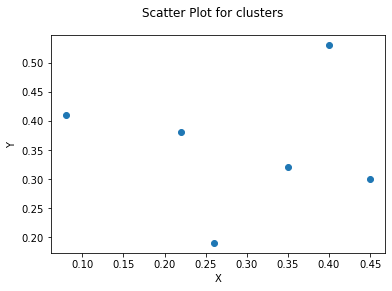

In [24]:
data = np.array([0.40,0.53,0.22,0.38,0.35,0.32,0.26,0.19,0.08,0.41,0.45,0.30]).reshape(6,2)
fig = plt.figure()
fig.suptitle('Scatter Plot for clusters')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(data[:,0],data[:,1])

In [25]:
def hierarchical_clustering(data,linkage,no_of_clusters):  
    #first step is to calculate the initial distance matrix
    #it consists distances from all the point to all the point
    color = ['r','g','b','y','c','m','k','w']
    initial_distances = pairwise_distances(data,metric='euclidean')
    #making all the diagonal elements infinity 
    np.fill_diagonal(initial_distances,sys.maxsize)
    clusters = find_clusters(initial_distances,linkage) 
    
    #plotting the clusters
    iteration_number = initial_distances.shape[0] - no_of_clusters
    clusters_to_plot = clusters[iteration_number]
    arr = np.unique(clusters_to_plot)
    
    indices_to_plot = []
    fig = plt.figure()
    fig.suptitle('Scatter Plot for clusters')
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for x in np.nditer(arr):
        indices_to_plot.append(np.where(clusters_to_plot==x))
    p=0
    
    print(clusters_to_plot)
    for i in range(0,len(indices_to_plot)):
        for j in np.nditer(indices_to_plot[i]):
               ax.scatter(data[j,0],data[j,1], c= color[p])
        p = p + 1
        
    plt.show()

In [26]:
def find_clusters(input,linkage):
    clusters = {}
    row_index = -1
    col_index = -1
    array = []
    

    for n in range(input.shape[0]):
        array.append(n)
        
    clusters[0] = array.copy()

    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    for k in range(1, input.shape[0]):
        min_val = sys.maxsize
        
        for i in range(0, input.shape[0]):
            for j in range(0, input.shape[1]):
                if(input[i][j]<=min_val):
                    min_val = input[i][j]
                    row_index = i
                    col_index = j
                    
        #once we find the minimum value, we need to update the distance matrix
        #updating the matrix by calculating the new distances from the cluster to all points
        
        #for Single Linkage
        if(linkage == "single" or linkage =="Single"):
            for i in range(0,input.shape[0]):
                if(i != col_index):
                    #we calculate the distance of every data point from newly formed cluster and update the matrix.
                    temp = min(input[col_index][i],input[row_index][i])
                    #we update the matrix symmetrically as our distance matrix should always be symmetric
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Complete Linkage
        elif(linkage=="Complete" or linkage == "complete"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = min(input[col_index][i],input[row_index][i])
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Average Linkage
        elif(linkage=="Average" or linkage == "average"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = (input[col_index][i]+input[row_index][i])/2
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        
        elif(linkage=="Centroid" or linkage =="centroid"):
            for i in range(0,input.shape[0]):
                if(i!=col_index and i!=row_index):
                    dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
                    input[col_index][i] = dist_centroid
                    input[i][col_index] = dist_centroid
                   
        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set input[row_index][for_all_i] = infinity
        #set input[for_all_i][row_index] = infinity
        for i in range (0,input.shape[0]):
            input[row_index][i] = sys.maxsize
            input[i][row_index] = sys.maxsize
            
        #Manipulating the dictionary to keep track of cluster formation in each step
        #if k=0,then all datapoints are clusters
       
        minimum = min(row_index,col_index)
        maximum = max(row_index,col_index)
        for n in range(len(array)):
            if(array[n]==maximum):
                array[n] = minimum
        clusters[k] = array.copy()
        
    return clusters

[0, 1, 1, 3, 1, 1]


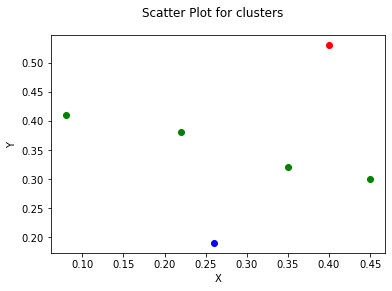

In [34]:
hierarchical_clustering(data,"complete",3)